Importing Libraries

In [84]:
import astropy
from astropy.timeseries import BoxLeastSquares
import lightkurve as lk
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import scipy
import math
import pandas as pd
import copy
import os
import warnings
import contextlib
from sklearn.linear_model import LinearRegression

%matplotlib inline

Initializing Constants and Preforming Setup

In [85]:
standard_figsize = (15, 7.5)
np.set_printoptions(edgeitems=25)
warnings.filterwarnings("ignore", category=astropy.time.core.TimeDeltaMissingUnitWarning)

# Dataframe with 1221 Short Period Exoplanets (P < 10 days)
sp_csv = pd.read_csv(filepath_or_buffer="ShortPeriodExoplanets.csv", comment="#")
sp_csv.set_index(keys="pl_name", inplace=True)
sp_csv.drop_duplicates(inplace=True)

# Kep78 Info, In Days
kep78b_timeline = 1424.89596
kep78b_period = 0.3550074
kep78b_duration = 0.0339167 

# Kepler-1520b Info, In Days
kep1520b_timeline = 1459.4893630790102
kep1520b_period = 0.6535555
kep1520b_duration = 0.0679167

Data Analysis Function Definitions

In [86]:
def getPeriodRange(period, timeline=4.1*365, buffer=1/24, low_buffer=None, up_buffer=None, spacing_coeff=0.01):
    # In Days
    if low_buffer is None:
        low_buffer = buffer
    if up_buffer is None:
        up_buffer = buffer
    spacing = spacing_coeff * (period  ** 2 / timeline) 
    return np.arange(period - low_buffer, period + up_buffer, spacing)  


def bin(y, bin_size, weights=None, mode="median"):
    if mode == "median":
        return scipy.signal.medfilt(y, kernel_size=bin_size)
    elif mode == "mean":
        if weights is None:
            weights = np.ones(bin_size) / bin_size
        elif len(weights) != bin_size:
            print("Warning, the length of the weights kernel isn't the same as bin_size")
        return np.convolve(np.pad(y, (bin_size // 2, bin_size // 2)), weights, mode="valid")
    else:
        print("Invalid mode for binning")


def timeBin(x, y, time_bin_size=None, bins=None, aggregate_func=np.mean):
    # Creates the array of time bins
    if bins is None:
        bins = np.arange(np.min(x), np.max(x), time_bin_size)  

    # Initialized the binned arrays with zeros
    x_binned = np.zeros((len(bins) - 1))
    y_binned = np.zeros((len(bins) - 1))

    # Splits the data into time bins using indices, indexes the data to access the bins, and preforms the aggregation function on the bins
    bin_locs = np.digitize(x, bins)
    for idx in range(1, len(bins)):
        bin = np.nonzero(bin_locs == idx)[0]  # np.nonzero wraps the array in a tuple for 1-D arrays
        if len(bin) == 0:
            x_binned[idx - 1] = np.nan
            y_binned[idx - 1] = np.nan
        else:
            x_binned[idx - 1] = aggregate_func(bins[idx-1:idx+1]) # Could also use x[bin] for uneven bins
            y_binned[idx - 1] = aggregate_func(y[bin])
    
    # Fills the nans added when the bin was empty using linear interpolation
    if np.isnan(x_binned).any():
        fillNans(x_binned)
    if np.isnan(y_binned).any():
        fillNans(y_binned)
    return x_binned, y_binned


def fillNans(y):
    x = np.indices(y.shape)[0]
    isnan = np.isnan(y)
    nan_x = x[isnan].astype(int)
    nan_y = np.interp(nan_x, x[~isnan], y[~isnan])
    y[nan_x] = nan_y
    return len(nan_x)


def removeOutliers(x, y, n_sigma):
    num_outliers = 0
    mean = np.nanmean(y)
    std = np.nanstd(y)
    x_clean = np.empty(0)
    y_clean = np.empty(0)
    for x, y in zip(x, y):
        if np.abs(y - mean) < n_sigma * std:
            x_clean = np.append(x_clean, x)
            y_clean = np.append(y_clean, y)
        elif not np.isnan(y):
            num_outliers += 1
    return x_clean, y_clean, num_outliers


def customBootstrap(x, y, n_samples):
    x_samples = np.zeros((n_samples, x.shape[0]))
    y_samples = np.zeros((n_samples, y.shape[0]))
    sample_idx = np.indices(y.shape)[0]

    for idx in range(n_samples):
        resample_idx = np.sort(np.random.choice(a=sample_idx, size=y.shape))
        x_samples[idx] = x[resample_idx]
        y_samples[idx] = y[resample_idx]
    
    return x_samples, y_samples


def customResidualBootstrap(x, n_samples, block_size, smooth_func):
    sample = np.pad(x, (0, block_size), mode="median")

    x_smooth = smooth_func(sample)
    residuals = sample - x_smooth
    samples = np.zeros((n_samples, sample.shape[0]))

    for n in range(n_samples):
        for idx in range(len(residuals) - block_size):
            residual_block = residuals[idx:idx + block_size]
            smooth_block = x_smooth[idx:idx + block_size]
            samples[n][idx:idx + block_size] = smooth_block + np.random.choice(a=residual_block, size=residual_block.shape)
    
    return samples[:, :-block_size]


def lowPassGaussian(frequency, cutoff):
    gaussian = lambda x: math.e ** ((-0.5) * (x / cutoff) ** 2)
    return np.apply_along_axis(gaussian, 0, frequency)


def filter(flux, filter_type, cutoff):
    # Obtaining the applying the filter
    n = len(flux)
    frequency = scipy.fft.rfftfreq(n, 1/48)
    filter = filter_type(frequency, cutoff)
    fft_data = scipy.fft.rfft(flux)
    flux_filtered = scipy.fft.irfft(fft_data * filter, n)

    # Return the processed signal
    return flux_filtered

def bls(time, flux, duration, period=None, target="period"):
    # Wrapper function for astropy box least squares
    model = BoxLeastSquares(time, flux)
    if period is None:
        period = model.autoperiod(duration=duration, frequency_factor=1)
    periodogram = model.power(period=period, duration=duration)
    best = np.argmax(periodogram.power)
    if target == "duration":
        return periodogram.duration[best]
    elif target == "depth":
        return periodogram.depth[best]
    elif target == "transit time":
        return periodogram.transit_time[best]
    else:
        return periodogram.period[best]

def fold(time, period, epoch=0):
    return (time - epoch) / period % 1

def cut(time, flux, period): 
    # Cuts the time and flux values into individual periods
    time_cut = []
    flux_cut = []
    cut = 0
    for idx in range(1, len(time)):
        if time[idx] % period < time[idx - 1] % period:
            time_cut.append(time[cut:idx])
            flux_cut.append(flux[cut:idx])
            cut = idx

    time_cut = np.array(time_cut, dtype=object)
    flux_cut = np.array(flux_cut, dtype=object)
    return np.stack(arrays=(time_cut, flux_cut), axis=-1)

Lightcurve Class

In [87]:
# Class to encapsulate a stellar light curve, consisting of time data, flux data, and phase data if the light curve has been folded
class LC:
    def __init__(self, time, flux):
        self.time = time
        self.flux = flux
        self.data = {"time": self.time, "flux": flux}
        self.has_folded = False

    def __repr__(self):
        return f"Light Curve Object with data {self.data}"

    def plot(self, mode="time", *args, **kwargs):
        if mode == "phase":
            if self.has_folded:
                plt.plot(self.phase, self.flux, *args, **kwargs)
                plt.title("Light curve")
                plt.xlabel(f"Phase")
                plt.ylabel("Flux")
            else:
                print("Warning, light curve hasn't been folded yet")
        else:
            plt.plot(self.time, self.flux, *args, **kwargs)
            plt.title("Light curve")
            plt.xlabel(f"Time (Days)")
            plt.ylabel("Flux")

        plt.show()

    def getTime(self):
        return self.time

    def getFlux(self):
        return self.flux

    def zip(self):
        return zip(self.time, self.flux)
    
    def fold(self, period, epoch=0, inplace=True):
        self.phase = fold(self.time, period, epoch=epoch)
        self.data["phase"] = self.phase
        self.has_folded = True
        if inplace:
            return self

    def append(self, lc):
        self.time = np.append(self.time, lc.time)
        self.flux = np.append(self.flux, lc.flux)
        return self

    def copy(self):
        return copy.deepcopy(self)

# Context manager that allows you to work with a folded light curve with phase sorted in index
@contextlib.contextmanager
def sortToPhase(lc):
    if lc.has_folded:
        sort_idx = np.argsort(lc.phase)
        lc.phase, lc.time, lc.flux = lc.phase[sort_idx], lc.time[sort_idx], lc.flux[sort_idx]
    yield lc
    sort_idx = np.argsort(lc.time)
    lc.time, lc.phase, lc.flux = lc.time[sort_idx], lc.phase[sort_idx], lc.flux[sort_idx]

Obtaining Data Function Definitions

In [88]:
def openFitsLightCurve(fits_file, include_image=False):
    with astropy.io.fits.open(name=fits_file, mode="readonly") as hdu:
        out = dataFromHDU(hdu=hdu, include_image=include_image)
    return out


def dataFromHDU(hdu, include_image=False, flux_column_name="SAP_FLUX"):
    # Extracting the data from the HDUList
    data = hdu[1].data
    flux = data[flux_column_name]
    time = data['time']
    
    if include_image:
        image = hdu[2].data
        lc = LC(time, flux)
        lc.data["image"] = image
        return lc
    else:
        return LC(time, flux)

Plot Creation Function Definitions

In [89]:
def produceTrendPlots(time, flux, filter_type, cutoff):
    plt.figure(figsize=standard_figsize)

    # 1) Plotting the original SAP Light curves
    plt.subplot(2, 3, 1)
    plt.plot(time, flux)
    plt.title("Original SAP Light curve")
    plt.xlabel("Time (days)")
    plt.ylabel("Flux (electrons/second)")

    n = len(flux)
    intensity = scipy.fft.rfft(flux)
    frequency = scipy.fft.rfftfreq(n, 1/48)
    cutoff_idx = np.where(frequency > cutoff)[0][0]

    # 2) Plotting the fourier transform of the sap light curves
    plt.subplot(2, 3, 2)
    plt.plot(frequency, np.abs(intensity))
    plt.plot(cutoff, np.abs(intensity)[cutoff_idx], color="r", marker="o", markersize=10, label="Filter Cutoff")
    plt.axvline(cutoff, color="r")
    plt.title("Fourier Transform of SAP flux")
    plt.yscale("log")
    plt.xlabel("Frequency")
    plt.ylabel("Intensity")
    plt.legend()

    # 3) Plotting the filter
    filter = filter_type(frequency, cutoff)

    plt.subplot(2, 3, 3)
    plt.plot(frequency, filter)
    plt.title("Lowpass Box Filter Frequency Response")
    plt.plot(cutoff, filter[cutoff_idx], color="r", marker="o", markersize=10, label="Filter Cutoff")
    plt.axvline(cutoff, color="r")
    plt.xlabel("Frequency")
    plt.legend()

    # Filtering the light curves
    fft_data = scipy.fft.rfft(flux)
    flux_filtered = scipy.fft.irfft(fft_data * filter, n)

    # 4) Plotting the trend removed from the light curve
    plt.subplot(2, 3, 4)
    plt.plot(time, flux_filtered)
    plt.xlabel("Time (Days)")
    plt.ylabel("Flux (Normalized Units)")
    plt.title("Long Term Trend Removed From Light Curve")

    # 5) Plotting the low pass filtered light curve over the original light curve
    plt.subplot(2, 3, 5)
    plt.plot(time, flux, label="Before Filtering")
    plt.plot(time, flux_filtered, label="After Filtering")
    plt.title("Original and Low Pass Filtered Light Curves")
    plt.xlabel("Time (Days)")
    plt.ylabel("Flux (Normalized Units)")
    plt.legend()

    # 6) Plotting the original sap light curve divided by the filtered light curve
    plt.subplot(2, 3, 6)
    plt.plot(time, flux / flux_filtered - 1.0)
    plt.title("Low Pass Trend Removed")
    plt.xlabel("Time (Days)")
    plt.ylabel("Flux (Normalized Units)")

    # 6.5) Plotting the Savitzky-Golay Filtered Data
    """
    flux_filtered_savgol = scipy.signal.savgol_filter(x=flux, window_length=3, polyorder=0)
    plt.subplot(2, 3, 6)
    plt.plot(time, flux / flux_filtered_savgol)
    plt.title("Low Pass Trend Removed Using Savitzky-Golay")
    plt.xlabel("Time (Days)")
    plt.ylabel("Flux (Normalized Units)")
    """


def produceBLSPeriodogramPlots(time, flux, duration, period=None, is_78b=False):
    plt.figure(figsize=standard_figsize)
    model = BoxLeastSquares(time, flux)
    if period is None:
        period = model.autoperiod(duration=duration, frequency_factor=1)
    periodogram = model.power(period=period, duration=duration, objective="snr")
    best = np.argmax(periodogram.power)
    best_period, best_duration, best_transit_time = periodogram.period[best], periodogram.duration[best], periodogram.transit_time[best]

    # 1) Plotting the original SAP Light curves
    plt.subplot(1, 2, 1)
    plt.plot(time, flux, label="SAP FLUX")
    plt.plot(time, model.model(time, best_period, best_duration, best_transit_time), label="BLS Transit Model", color="red")
    plt.title("Light Curve")
    plt.xlabel("Time (Days)")
    plt.ylabel("Flux (Normalized Units)")
    plt.legend()

    # 2) Plotting the BLS periodogram
    plt.subplot(1, 2, 2)
    plt.plot(periodogram.period, periodogram.power, label="BLS Periodogram")
    if is_78b:
        plt.axvline(kep78b_period, label="Period of Kepler-78b from the Literature", linestyle="--", color="red")
    plt.title("Box Least Squares Periodogram")
    plt.xlabel("Period (Days)")
    plt.ylabel("BLS Power")
    plt.legend()

    return best_period


def produceFoldPlots(time, flux, period, include_boot=False, n_samples=25, **kwargs):
    plt.figure(figsize=standard_figsize)

    phase = fold(time, period)
    plt.scatter(phase, flux, s=0.5, label="Phase folded light curve")

    if include_boot:
        phase_samples, flux_samples = customBootstrap(phase, flux, n_samples=n_samples)
        for p, f in zip(phase_samples, flux_samples):
            p_binned, f_binned = timeBin(p, f, **kwargs)
            plt.plot(p_binned, f_binned - np.mean(f_binned), alpha=0.3, color="orange")
    
    phase_binned, flux_binned = timeBin(phase, flux, **kwargs)
    plt.plot(phase_binned, flux_binned, linewidth=2, color="r", label="Binned phase folded light curve")

    plt.title(f"Phase folded light curve with period: {period}")
    plt.xlabel("Phase")
    plt.ylabel("Flux (Normalized Units)")


def produceFoldPlotsAnimation(time, flux, period_grid, duration, write=False):
    # Creates an animation of the flux folded on a given period grid of period and bls powers of the period grid
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.set(figheight=standard_figsize[1], figwidth=standard_figsize[0])
    fig.suptitle("Phase Folded Light Curve and BLS Power With Varying Periods")

    plt.subplot(2, 1, 1)
    ax1.set_xlim(0, 1)
    ax1.set_ylim(np.min(flux) - np.std(flux), np.max(flux) + np.std(flux))
    scatter, = ax1.plot([], [], linewidth=0, marker='o', markersize=0.5)
    plt.xlabel("Phase")
    plt.ylabel("Flux (Normalized Units)")

    model = BoxLeastSquares(time, flux)
    periodogram = model.power(period=period_grid, duration=duration)

    plt.subplot(2, 1, 2)
    ax2.plot(periodogram.period, periodogram.power)
    plt.xlabel("Period (Days)")
    plt.ylabel("BLS Power")
    point, = ax2.plot([], [], marker='o', markersize=5, color='r')

    def init():
        scatter.set_data([], [])
        point.set_data([], [])
        return scatter, point,

    def animate(i):
        phase = fold(time, i)
        scatter.set_data(phase, flux)
        point.set_data([i], periodogram.power[np.where(period_grid == i)])
        return scatter, point,

    writer = matplotlib.animation.FFMpegWriter(fps=30)

    anim = matplotlib.animation.FuncAnimation(fig=fig, func=animate, init_func=init, frames=period_grid, interval=50, blit=True, repeat=False)

    if write:
        anim.save(filename="FoldedAnimation.mp4", writer=writer)

    plt.show()


def produceFoldPlotsInteractive(time, flux, period_grid, duration, initial_period=None):
    # Creates an interactive animation of the flux folded on a given period grid of period and bls powers of the period grid
    if initial_period is None:
        initial_period = period_grid[len(period_grid) // 2]

    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.set(figheight=standard_figsize[1], figwidth=standard_figsize[0])
    fig.suptitle("Phase Folded Light Curve and BLS Power With Varying Periods")

    phase = fold(time, initial_period)

    plt.subplot(2, 1, 1)
    scatter, = ax1.plot(phase, flux, linewidth=0, marker='o', markersize=0.5)
    plt.xlabel("Phase")
    plt.ylabel("Flux (Normalized Units)")

    model = BoxLeastSquares(t=time, y=flux)
    periodogram = model.power(period=period_grid, duration=duration)
    loc = periodogram.power[np.where(period_grid == initial_period)]

    plt.subplot(2, 1, 2)
    ax2.plot(periodogram.period, periodogram.power)
    plt.xlabel("Period (Days)")
    plt.ylabel("BLS Power")
    point, = ax2.plot([initial_period], loc, marker='o', markersize=5, color='r')

    def update(val):
        phase = fold(time, val)
        scatter.set_data(phase, flux)
        point.set_data([val], periodogram.power[np.where(period_grid == val)])
        fig.canvas.draw_idle()

    period_ax = plt.axes([0.13, 0.02, 0.75, 0.03])
    period_slider = matplotlib.widgets.Slider(ax=period_ax, label="Period", valmin=period_grid[0], valmax=period_grid[-1], valstep=period_grid, valinit=initial_period)
    period_slider.on_changed(update)

    plt.show()


def produceSingleTransitPlotsAnimation(transits_cut, phase, flux, period, write=False):
    # Creates an animation of shifting individual transits overlayed on the entire folded light curve
    fig, ax = plt.subplots()
    fig.set(figheight=standard_figsize[1], figwidth=standard_figsize[0])
    fig.suptitle("Varying transits plotted over the complete folded light curve")

    ax.set_xlim(np.min(phase) - np.std(phase), np.max(phase) + np.std(phase))
    ax.set_ylim(np.min(flux) - np.std(flux), np.max(flux) + np.std(flux))
    folded, = ax.plot([], [], lw=0, marker='o', markersize=0.5, label="Complete folded light curve")
    transit, = ax.plot([], [], color="r", label="Nth transit")
    plt.xlabel("Phase")
    plt.ylabel("Flux (Normalized Units)") 
    plt.legend()
 
    def init():
        folded.set_data(phase, flux)
        transit.set_data([], [])
        return folded, transit,

    def animate(i):
        transit_time, transit_flux = i
        transit_phase = fold(transit_time, period)
        folded.set_data(phase, flux)
        transit.set_data(transit_phase, transit_flux)
        return folded, transit,

    writer = matplotlib.animation.FFMpegWriter(fps=10)

    anim = matplotlib.animation.FuncAnimation(fig=fig, func=animate, init_func=init, frames=transits_cut, interval=20, blit=True)

    if write:
        anim.save(filename="TransitAnimation.mp4", writer=writer)

    plt.show()


def produceSingleTransitPlotsInteractive(transits_cut, phase, flux, period):
    # Creates an interactive animation of shifting individual transits overlayed on the entire folded light curve
    fig, ax = plt.subplots()
    fig.set(figheight=standard_figsize[1], figwidth=standard_figsize[0])
    fig.suptitle("Varying transits plotted over the complete folded light curve")

    n_transits = len(transits_cut)

    transit_time, transit_flux = transits_cut[0]
    transit_phase = fold(transit_time, period)
    folded, = ax.plot(phase, flux, lw=0, marker='o', markersize=0.5, label="Complete folded light curve")
    transit, = ax.plot(transit_phase, transit_flux, color="r", label="Nth transit")
    minimum, = ax.plot(transit_phase[np.argmin(transit_flux)], np.min(transit_flux), color='b', marker='o', markersize=4, label="Min",)
    maximum, = ax.plot(transit_phase[np.argmax(transit_flux)], np.max(transit_flux), color='g', marker='o', markersize=4, label="Max")
    plt.xlabel("Phase")
    plt.ylabel("Flux (Normalized Units)") 
    plt.legend()

    def update(val):
        transit_time, transit_flux = transits_cut[val]
        transit_phase = fold(transit_time, period)
        folded.set_data(phase, flux)
        transit.set_data(transit_phase, transit_flux)
        minimum.set_data(transit_phase[np.argmin(transit_flux)], np.min(transit_flux))
        maximum.set_data(transit_phase[np.argmax(transit_flux)], np.max(transit_flux))
        fig.canvas.draw_idle()

    transit_ax = plt.axes([0.13, 0.02, 0.75, 0.03])
    transit_slider = matplotlib.widgets.Slider(ax=transit_ax, label="Number transit", valmin=0, valmax=n_transits - 1, valstep=np.arange(0, n_transits), valinit=0)
    transit_slider.on_changed(update)

    plt.show()


def produceQuarterPeriodPlots(time, period_list):
    plt.figure(figsize=standard_figsize)

    X = time.reshape((-1, 1))
    y = period_list
    
    period_linreg = LinearRegression().fit(X, y)
    plt.scatter(time, period_list, s=8)
    plt.plot(time, period_linreg.predict(X), linewidth=2, color="red")
    plt.title(f"Best fit period for every quarter (R squared = {period_linreg.score(X, y)})")
    plt.xlabel("Time (Days)")
    plt.ylabel("Best fit period (days)")


def produceTimeBinPlots(time, lc_list, reference_lc, period, spacing, include_boot=False, n_samples=25, **kwargs):
    if time is None:
        time = np.zeroes_like(lc_list)
        for idx, quarter_lc in enumerate(lc_list):
            time[idx] = np.median(quarter_lc.time)
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set(figheight=standard_figsize[1], figwidth=standard_figsize[0])
    fig.suptitle("Phase Curves of Every Quarter With and Without a Reference Curve Subtracted Out")

    ax1.set_title("Phase Curves")
    ax1.set_xlabel("Phase")
    ax1.set_ylabel("Flux (Normalized Units)")
    
    ax2.set_title("Reference Curve Subtracted Out")
    ax2.set_xlabel("Phase")
    ax2.set_ylabel("Flux (Normalized Units)")
    
    cmap = matplotlib.cm.get_cmap("winter")
    cmap_sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=matplotlib.colors.Normalize(time[0], time[-1]))
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="2%", pad=0.1)
    
    ref_phase_binned, ref_flux_binned = timeBin(reference_lc.phase, reference_lc.flux, **kwargs)

    # Pipeline to apply to every quarter
    for idx, quarter_lc in enumerate(lc_list):
        quarter_lc.fold(period)

        if include_boot:
            phase_samples, flux_samples = customBootstrap(quarter_lc.phase, quarter_lc.flux, n_samples=n_samples)
            for p, f in zip(phase_samples, flux_samples):
                p_binned, f_binned = timeBin(p, f, **kwargs)
                ax1.plot(p_binned, f_binned - np.mean(f_binned) - spacing * idx, alpha=0.3, color="orange")

        phase_binned, flux_binned = timeBin(quarter_lc.phase, quarter_lc.flux, **kwargs)
        ax1.plot(phase_binned, flux_binned - np.mean(flux_binned) - spacing * idx, c=cmap(idx / len(lc_list)))
        ax2.plot(phase_binned, flux_binned - ref_flux_binned - np.mean(flux_binned) - spacing * idx, c=cmap(idx / len(lc_list)))

    fig.colorbar(cmap_sm, label="Median Quarter Time (Days)", cax=cax)


def produceFrequencyBinPlots(lc_list, period, spacing, frequencies, time=None, **kwargs):
    if time is None:
        time = np.zeroes_like(lc_list)
        for idx, quarter_lc in enumerate(lc_list):
            time[idx] = np.median(quarter_lc.time)
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set(figheight=standard_figsize[1], figwidth=standard_figsize[0])

    ax1.set_title("Folded Light Curves Weighted With Varying Frequencies")
    ax2.set_title("Sine and Cosine curves used as weights")
    ax1.set_xlabel("Phase")
    ax2.set_xlabel("Time")

    lc_avg = 0
    for n, quarter_lc in enumerate(lc_list):
        quarter_lc.fold(period)
        phase_binned, flux_binned = timeBin(quarter_lc.phase, quarter_lc.flux, **kwargs)
        lc_avg += flux_binned
    lc_avg /= len(lc_list)
    ax1.plot(phase_binned, lc_avg, color="green")
    ax2.plot(time, np.ones_like(time), color="green")

    for idx, f in enumerate(frequencies):
        lc_avg_sin = 0
        lc_avg_cos = 0
        for n, quarter_lc in enumerate(lc_list):
            phase_binned, flux_binned = timeBin(quarter_lc.phase, quarter_lc.flux, **kwargs)
            lc_avg_sin += flux_binned * np.sin(time[n] * f)
            lc_avg_cos += flux_binned * np.cos(time[n] * f)
        ax1.plot(phase_binned, lc_avg_sin - np.mean(lc_avg_sin) - spacing * (idx + 1), color="red")
        ax1.plot(phase_binned, lc_avg_cos - np.mean(lc_avg_cos) - spacing * (idx + 1), color="blue")
        ax2.plot(time, np.sin(time * f) - 3 * (idx + 1), color="red")
        ax2.plot(time, np.cos(time * f) - 3 * (idx + 1), color="blue")

Data Wrangling for a Single Quarter

Target List:
- target: Kepler-78b, notes: primary target for analysis
- target: Kepler-1520b, notes: disintegrating planet
- Kepler-41 b, notes: hot Jupiter
- Kepler-12 b, notes: hot Jupiter
- Kepler-17 b, notes: transit timing variations
- Kepler-7 b, notes: hot Jupiter
- Kepler-42 c, notes: extremely short period

Quarter: 2
5 nan flux values were filled in, 26 outliers were removed
Number of data points: 4049, timeline: 88.70252596304636 days
0.6536125741551331
Period of Kepler-1520 b obtained from BLS periodogram: 0.6536125741551331 Days or 15.686701779723194 Hours


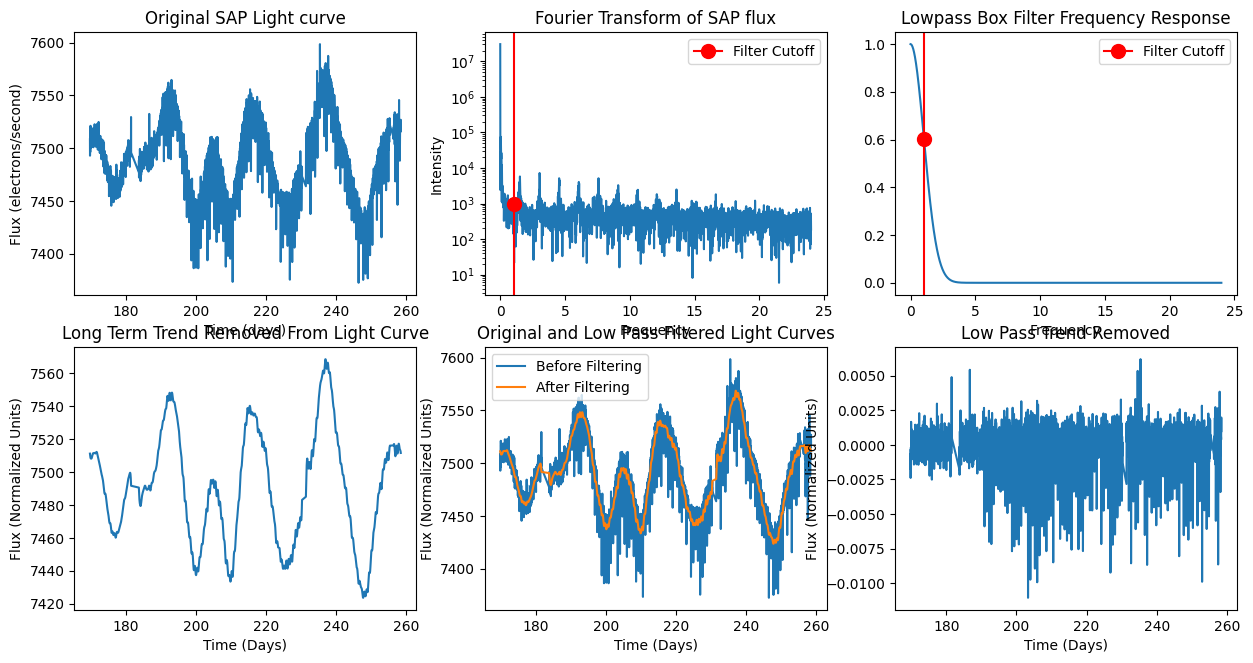

In [90]:
# Initialize Target Constants
target = "Kepler-1520 b"
if target in sp_csv.index:
    prior_period = sp_csv.loc[target, "pl_orbper"]
    target_period_range = getPeriodRange(period=prior_period)
    target_duration = sp_csv.loc[target, "pl_trandur"] / 24
    if np.isnan(target_duration):
        print("Target duration not found in provided CSV file")
        target_duration = np.linspace(1/24, prior_period / 2, 100)  # The largest duration would be no greater than half the period
else:
    print("Warning, target not found in provided CSV file")
    prior_period = 1
    target_period_range = None
    target_duration = 1/24
quarter = 2
filter_cutoff = 1 / prior_period - 0.5  # Filter cutoff is the frequency in the literature minus a small buffer

print("=" * 100)

# Obtain data using lightkurve (Warning happens on following line)
hdu = lk.search_lightcurve(quarter=quarter, target=target, mission="Kepler", exptime="long").download().to_fits()
quarter_lc = dataFromHDU(hdu=hdu, flux_column_name="FLUX")

# Obtain data from fits files
"""
filename = "KeplerFitsData/Kepler/kplr008435766_lc_Q111111111111111111/008435766/kplr008435766-2009166043257_llc.fits"
quarter_lc = openFitsLightCurve(fits_file=filename)
"""

print(f"Quarter: {quarter}")

# Preprocess data by removing Nan values, and filtering out long term trends
num_nans = fillNans(quarter_lc.flux)
produceTrendPlots(time=quarter_lc.time, flux=quarter_lc.flux, filter_type=lowPassGaussian, cutoff=filter_cutoff)
trend = filter(quarter_lc.flux, filter_type=lowPassGaussian, cutoff=filter_cutoff)
quarter_lc.flux = quarter_lc.flux/trend - 1.0
quarter_lc.time, quarter_lc.flux, num_outliers = removeOutliers(quarter_lc.time, quarter_lc.flux, n_sigma=5)
print(f"{num_nans} nan flux values were filled in, {num_outliers} outliers were removed")
print(f"Number of data points: {len(quarter_lc.time)}, timeline: {quarter_lc.time[-1] - quarter_lc.time[0]} days")

# Obtaining new data and constants with a variety of data analysis techniques
period = bls(quarter_lc.time, quarter_lc.flux, duration=target_duration, period=target_period_range)
print(period)
period_grid = getPeriodRange(period=period, buffer=1/(24*60))
print(f"Period of {target} obtained from BLS periodogram: {period} Days or {period * 24} Hours")
quarter_lc.fold(period)
print("=" * 100)

Plots for a Single Quarter

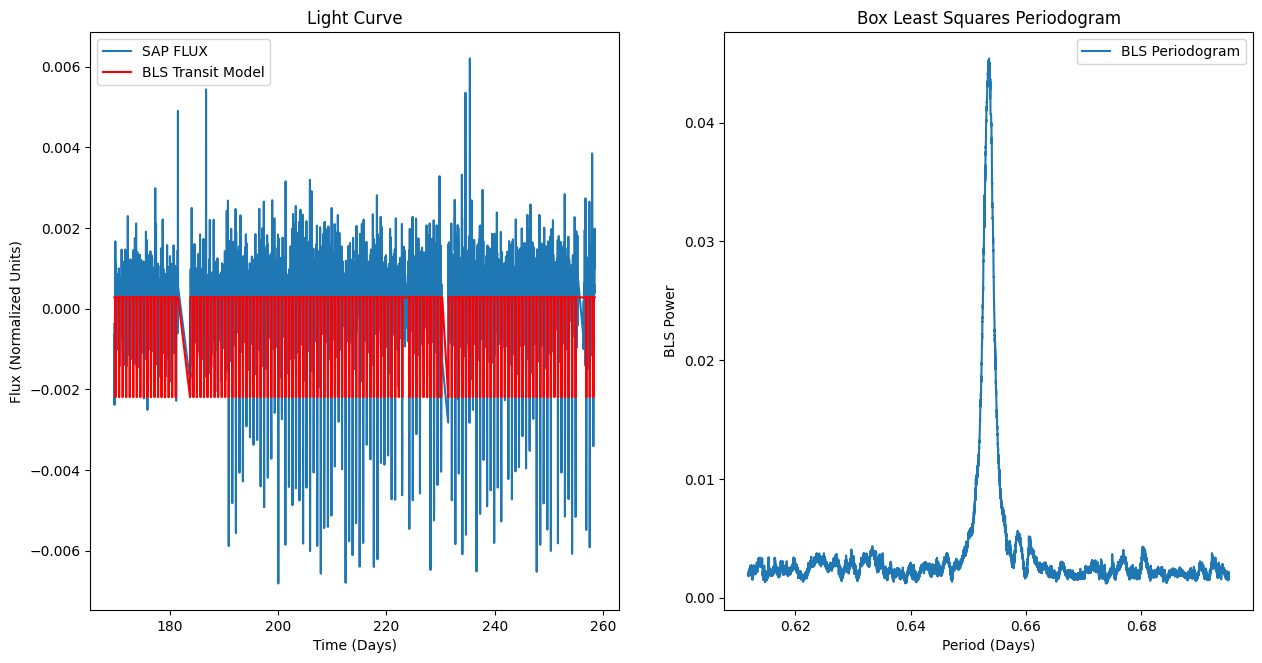

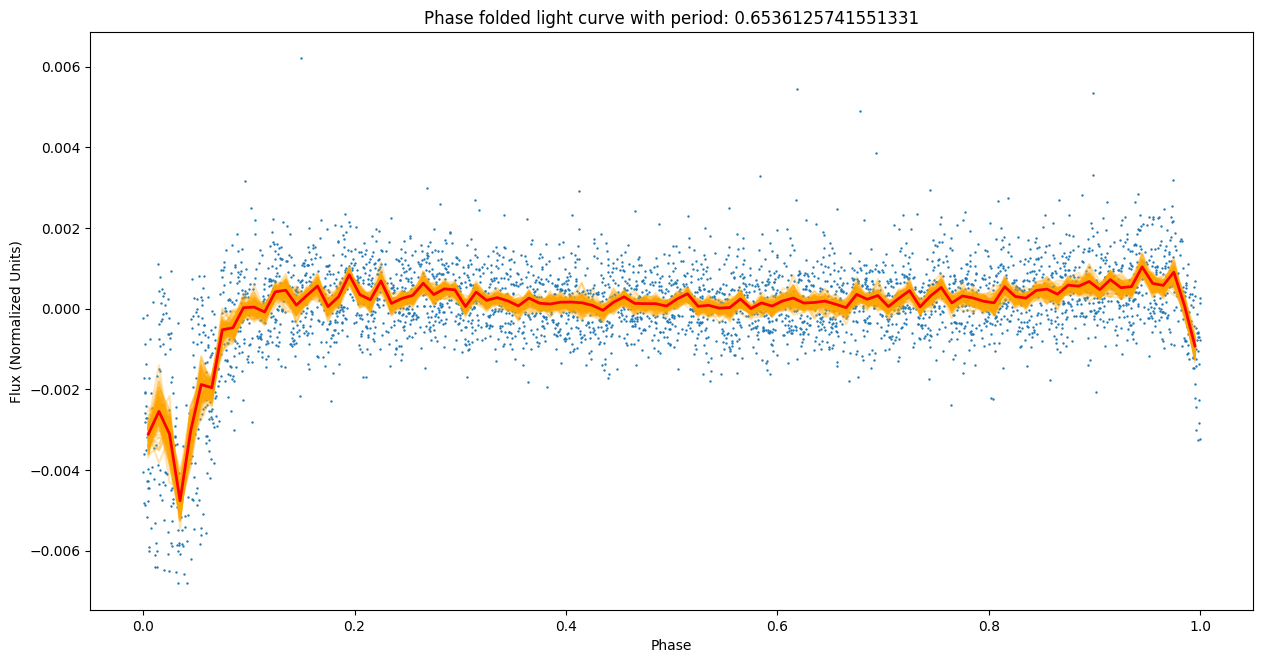

In [91]:
# Producing a variety of informative plots and interactive plots
produceBLSPeriodogramPlots(time=quarter_lc.time, flux=quarter_lc.flux, duration=target_duration, period=target_period_range)
produceFoldPlots(time=quarter_lc.time, flux=quarter_lc.flux, period=period, include_boot=True, n_samples=100, bins=np.arange(0, 1.01, 0.01), aggregate_func=np.mean)
# produceFoldPlotsInteractive(time=quarter_lc.time, flux=quarter_lc.flux, period_grid=period_grid, duration=target_duration)
# produceFoldPlotsAnimation(quarter_lc.time, quarter_lc.flux, period_grid, target_duration)

plt.show()

Data Wrangling for Multiple Quarters

Target List:
- target: Kepler-78b, notes: primary target for analysis
- target: Kepler-1520b, notes: disintegrating planet
- Kepler-41 b, notes: hot Jupiter
- Kepler-12 b, notes: hot Jupiter
- Kepler-17 b, notes: transit timing variations
- Kepler-7 b, notes: hot Jupiter
- Kepler-42 c, notes: extremely short period

In [92]:
# Initialize target constants
target = "Kepler-1520 b"
if target in sp_csv.index:
    prior_period = sp_csv.loc[target, "pl_orbper"]
    target_period_range = getPeriodRange(period=prior_period)
    target_duration = sp_csv.loc[target, "pl_trandur"] / 24
    if np.isnan(target_duration):
        print("Target duration not found in provided CSV file")
        target_duration = np.linspace(1/24, prior_period / 2, 100)  # The largest duration would be no greater than half the period
else:
    print("Warning, target not found in provided CSV file")
    prior_period = 1
    target_period_range = None
    target_duration = 1/24

# Obtain data from lightkurve
search_result = lk.search_lightcurve(target=target, mission="Kepler", exptime="long")

# Obtain data from fits file
"""
path = "KeplerFitsData/Kepler/kplr008435766_lc_Q111111111111111111/008435766"
exclude = ["desktop.ini"]
header, footer = "kplr008435766-", "_llc.fits"
search_result = os.listdir(path)
for name in exclude:
    if name in search_result:
        search_result.remove(name)
search_result = sorted(search_result, key=lambda name: int(name[len(header):-len(footer)]))
"""

lc = LC(np.empty(0), np.empty(0))
filter_cutoff = 1 / prior_period - 0.5  # Filter cutoff is the frequency in the literature minus a small buffer

period_list = np.zeros((len(search_result)), dtype=float)
time_list = np.zeros((len(search_result)), dtype=float)
lc_list = np.zeros((len(search_result)), dtype=object)

# Pipeline to apply to every quarter
for idx, result in enumerate(search_result):
    print("=" * 100)

    # Obtain data using lightkurve (Warning happens on following line)
    hdu = result.download().to_fits()
    quarter_lc = dataFromHDU(hdu=hdu, flux_column_name="FLUX")
    
    # Obtain data from fits file
    """
    quarter_lc = openFitsLightCurve(fits_file=path + "/" + result)
    print(path + "/" + result)
    """

    # Preprocess data by removing Nan values, and filtering out long term trends
    time_list[idx] = np.median(quarter_lc.time)
    print(f"Quarter: {idx + 1}")
    num_nans = fillNans(quarter_lc.flux)
    trend = filter(quarter_lc.flux, lowPassGaussian, filter_cutoff)
    quarter_lc.flux = quarter_lc.flux / trend - 1.0 
    quarter_lc.time, quarter_lc.flux, num_outliers = removeOutliers(quarter_lc.time, quarter_lc.flux, n_sigma=5)
    print(f"{num_nans} nan flux values were filled in, {num_outliers} outliers were removed")
    print(f"Number of data points: {len(quarter_lc.time)}, timeline: {quarter_lc.time[-1] - quarter_lc.time[0]} days, Median Time: {time_list[idx]}")
    
    # Obtaining best fits periods
    period = bls(quarter_lc.time, quarter_lc.flux, target_duration, period=target_period_range)
    period_list[idx] = period
    print(f"Period of {target} obtained from BLS periodogram: {period} Days or {period * 24} Hours")

    # Appending the quarter specific lc for later use
    lc_list[idx] = quarter_lc
    lc.append(quarter_lc)

print("=" * 100)

timeline = lc.time[-1] - lc.time[0]
print(f"Number of data points: {len(lc.time)}, timeline: {timeline} days")

# Obtaining new data and constants with a variety of data analysis techniques
period = bls(lc.time, lc.flux, duration=target_duration, period=target_period_range)
period_grid = getPeriodRange(period=period, buffer=1 / (24 * 60))
lc.fold(period)
print(f"Period of {target} obtained from BLS periodogram: {period} Days or {period * 24} Hours")
# print(f"Standard deviation of periods with quarter 0: {np.std(periods)}, without quarter 0: {np.std(periods[1:])}")
spacing = np.nanstd(lc.flux) * 2.5
frequencies = [i * (2 * math.pi / (timeline)) for i in range(1, len(lc_list) // 2 + 1)]

lc_list_cut = cut(lc.time, lc.flux, period)
for quarter_lc in lc_list:
    quarter_lc.fold(period)

Quarter: 1
2 nan flux values were filled in, 9 outliers were removed
Number of data points: 1617, timeline: 33.47116831074527 days, Median Time: 148.23735351098003
Period of Kepler-1520 b obtained from BLS periodogram: 0.6539807670230455 Days or 15.695538408553093 Hours
Quarter: 2
5 nan flux values were filled in, 26 outliers were removed
Number of data points: 4049, timeline: 88.70252596304636 days, Median Time: 213.98358965930674
Period of Kepler-1520 b obtained from BLS periodogram: 0.6536125741551331 Days or 15.686701779723194 Hours
Quarter: 3
6 nan flux values were filled in, 33 outliers were removed
Number of data points: 4107, timeline: 89.27183761646302 days, Median Time: 304.73785875850444
Period of Kepler-1520 b obtained from BLS periodogram: 0.6536810751538145 Days or 15.688345803691547 Hours
Quarter: 4
8 nan flux values were filled in, 23 outliers were removed
Number of data points: 4093, timeline: 89.82580754804076 days, Median Time: 395.74700953921274
Period of Kepler-152

Plots for Multiple Quarters

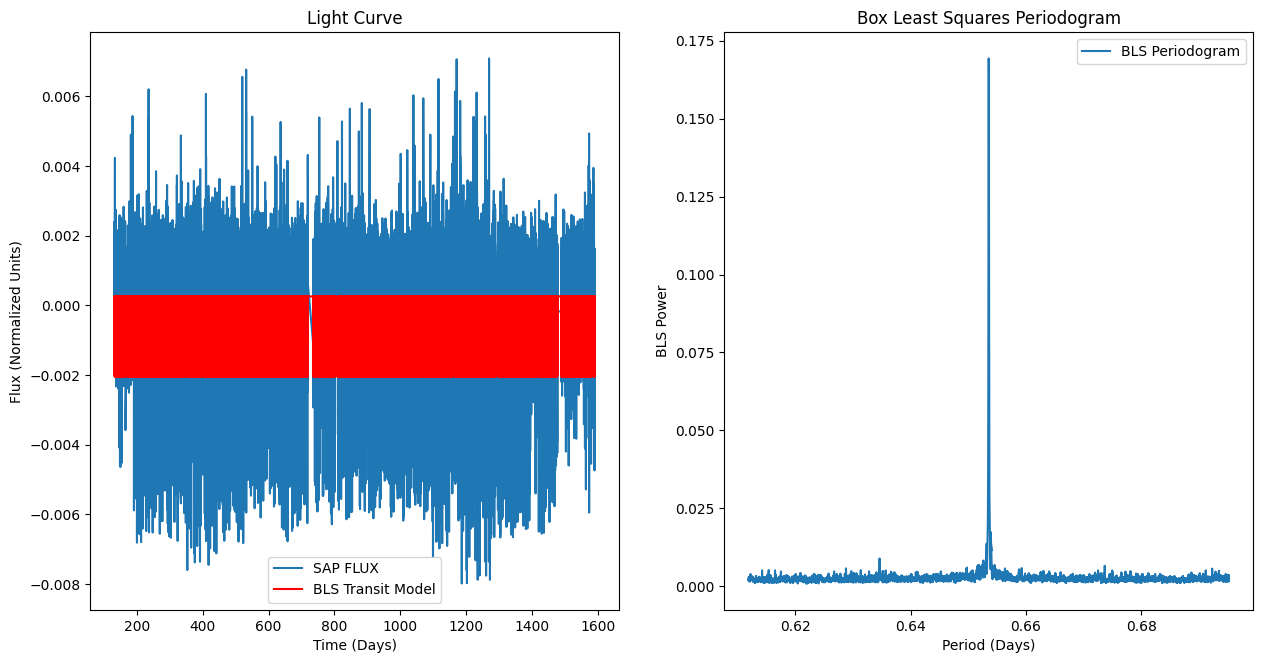

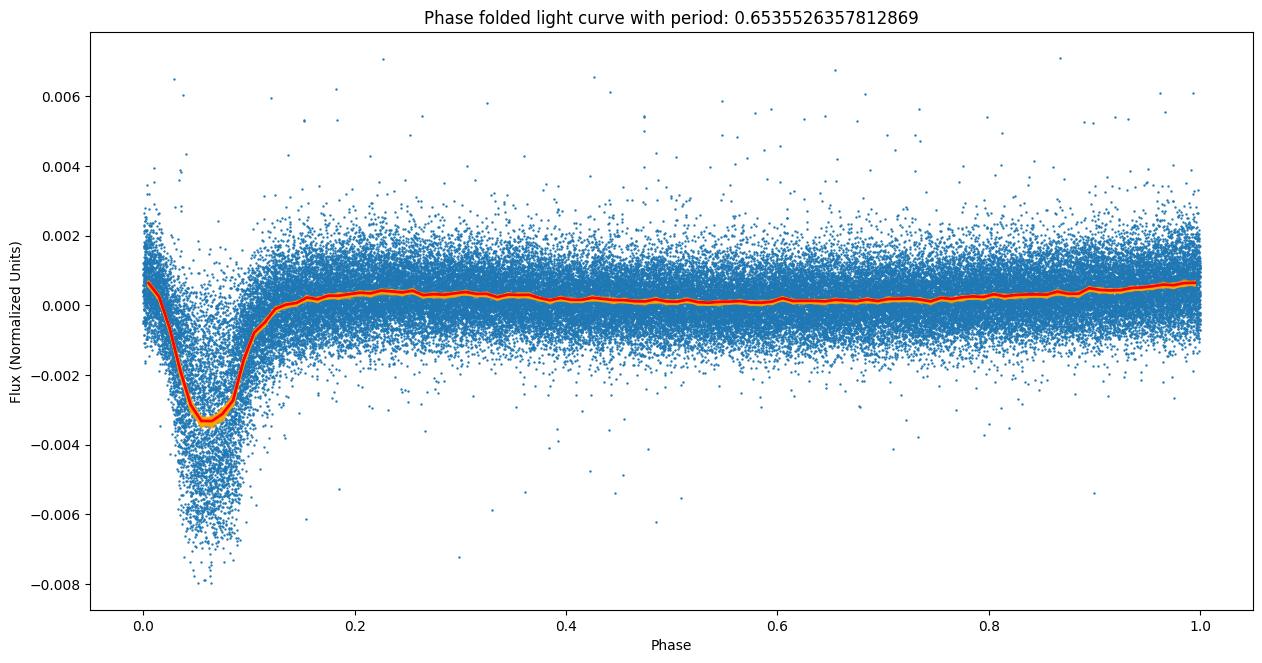

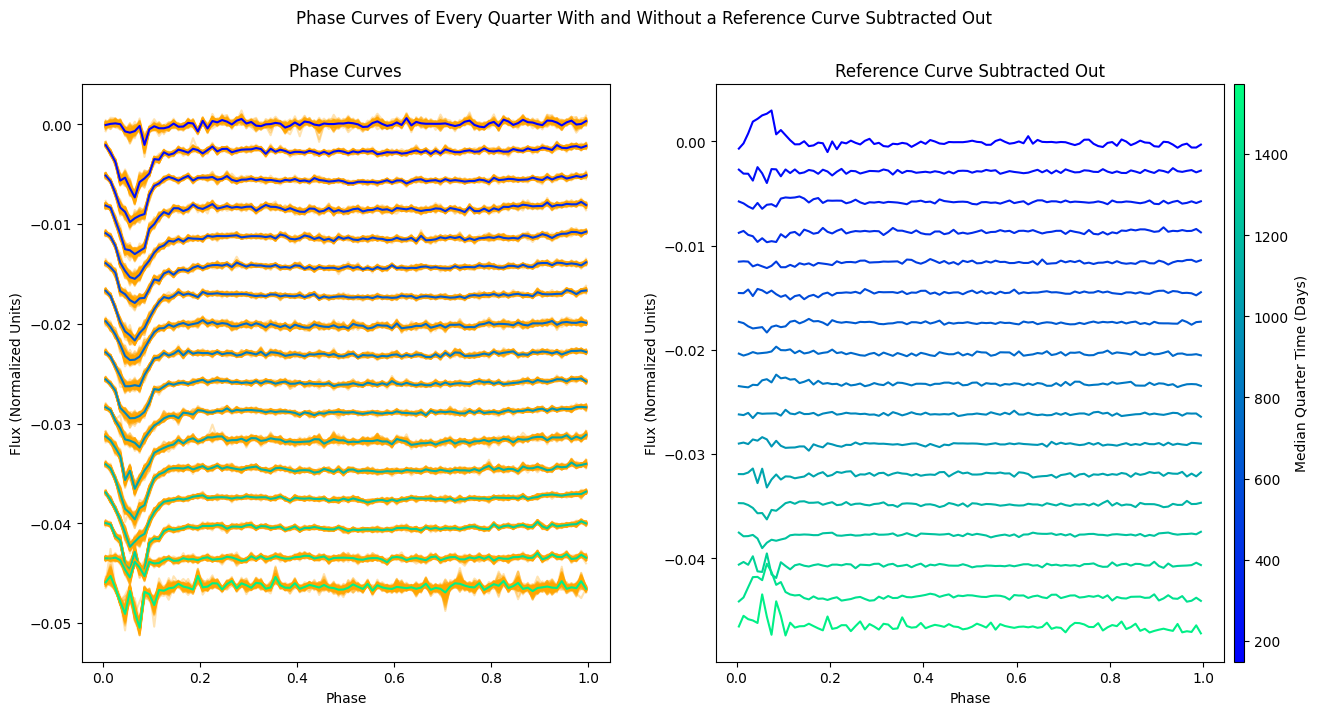

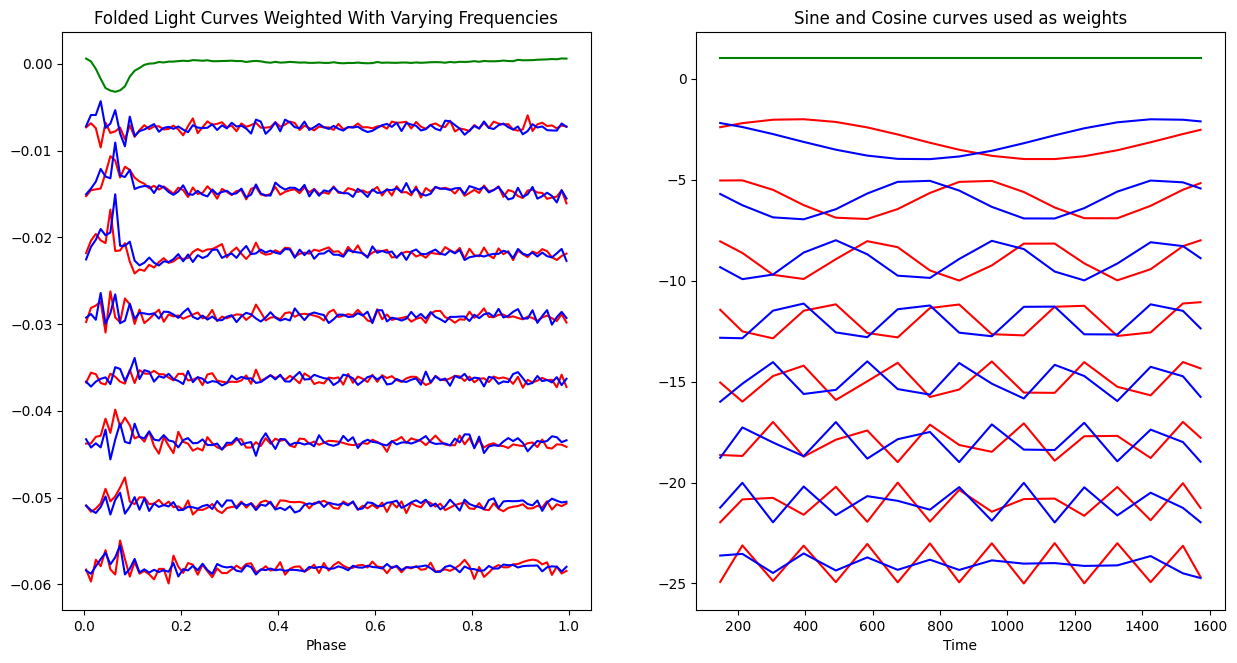

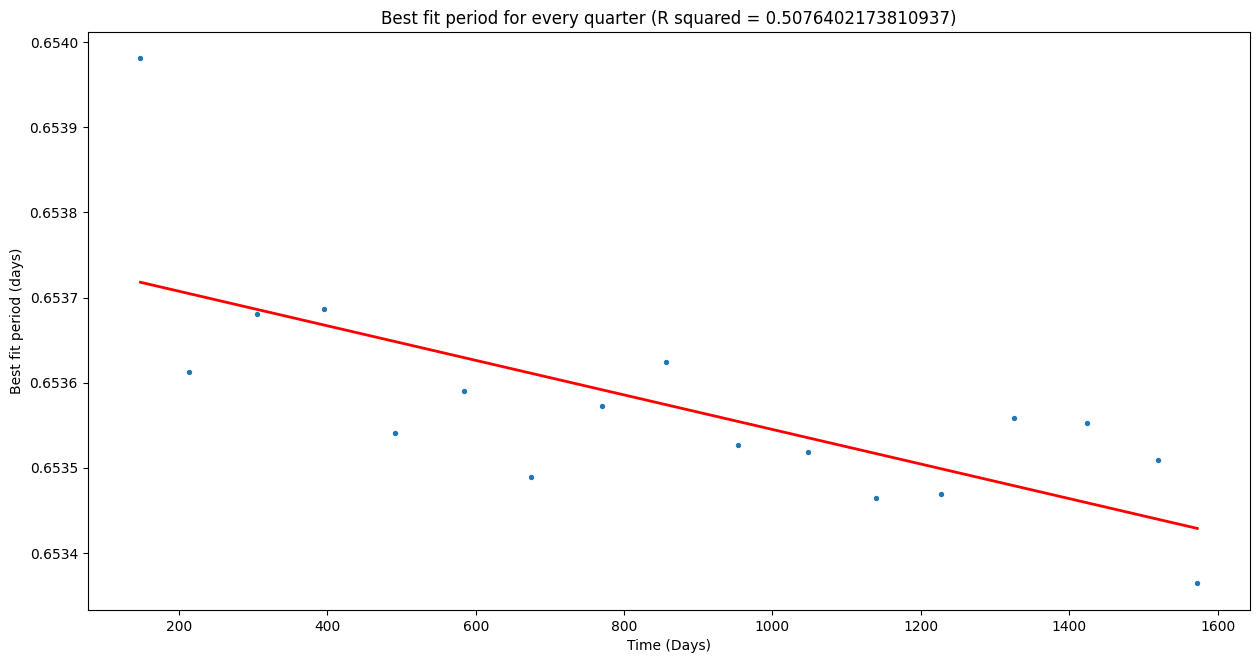

In [93]:
# Producing a variety of informative plots and interactive plots
produceBLSPeriodogramPlots(time=lc.time, flux=lc.flux, duration=target_duration, period=target_period_range)
produceFoldPlots(time=lc.time, flux=lc.flux, period=period, include_boot=True, n_samples=100, bins=np.arange(0, 1.01, 0.01), aggregate_func=np.mean)
produceTimeBinPlots(lc_list=lc_list, reference_lc=lc, period=period, spacing=spacing, include_boot=True, n_samples=100, time=time_list, bins=np.arange(0, 1.01, 0.01), aggregate_func=np.mean)
produceFrequencyBinPlots(lc_list=lc_list, period=period, spacing=spacing * 2.5, frequencies=frequencies, time=time_list, bins=np.arange(0, 1.01, 0.01), aggregate_func=np.mean)
produceQuarterPeriodPlots(time=time_list, period_list=period_list)
# produceFoldPlotsInteractive(time=lc.time, flux=lc.flux, period_grid=period_grid, duration=target_duration)
# produceFoldPlotsAnimation(time=lc.time, flux=lc.flux, period_grid=period_grid, duration=target_duration)

plt.show()

Model Fitting for a Single Quarter and Multiple Quarters

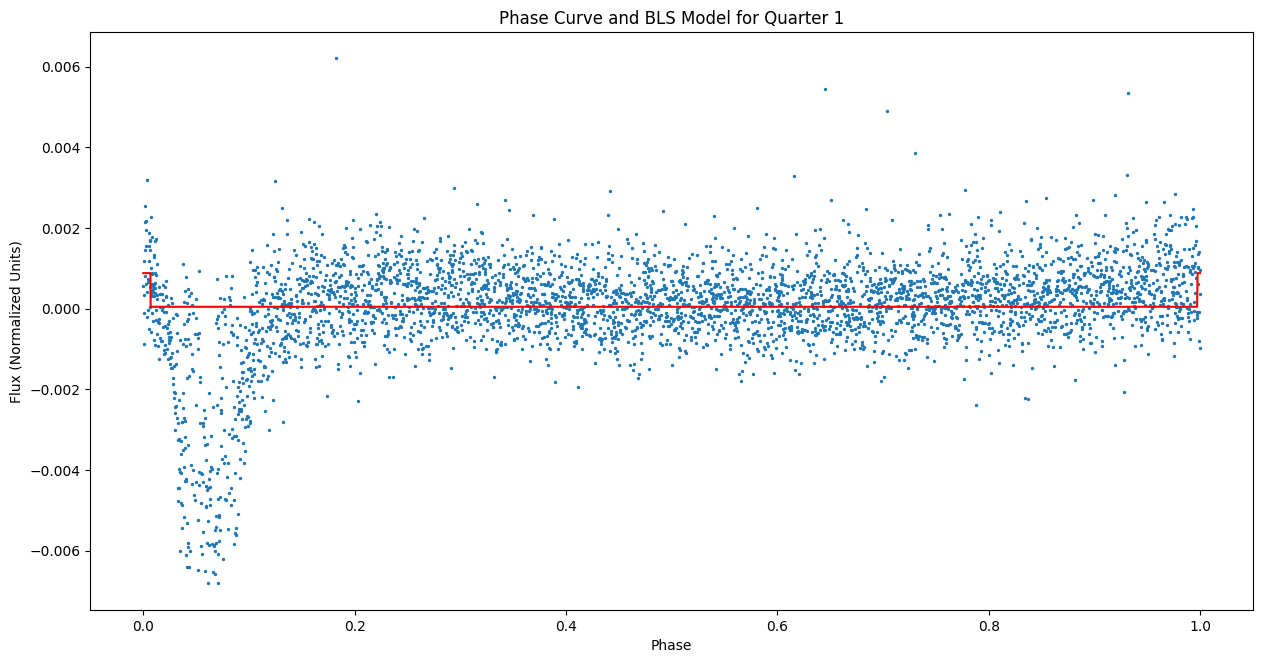

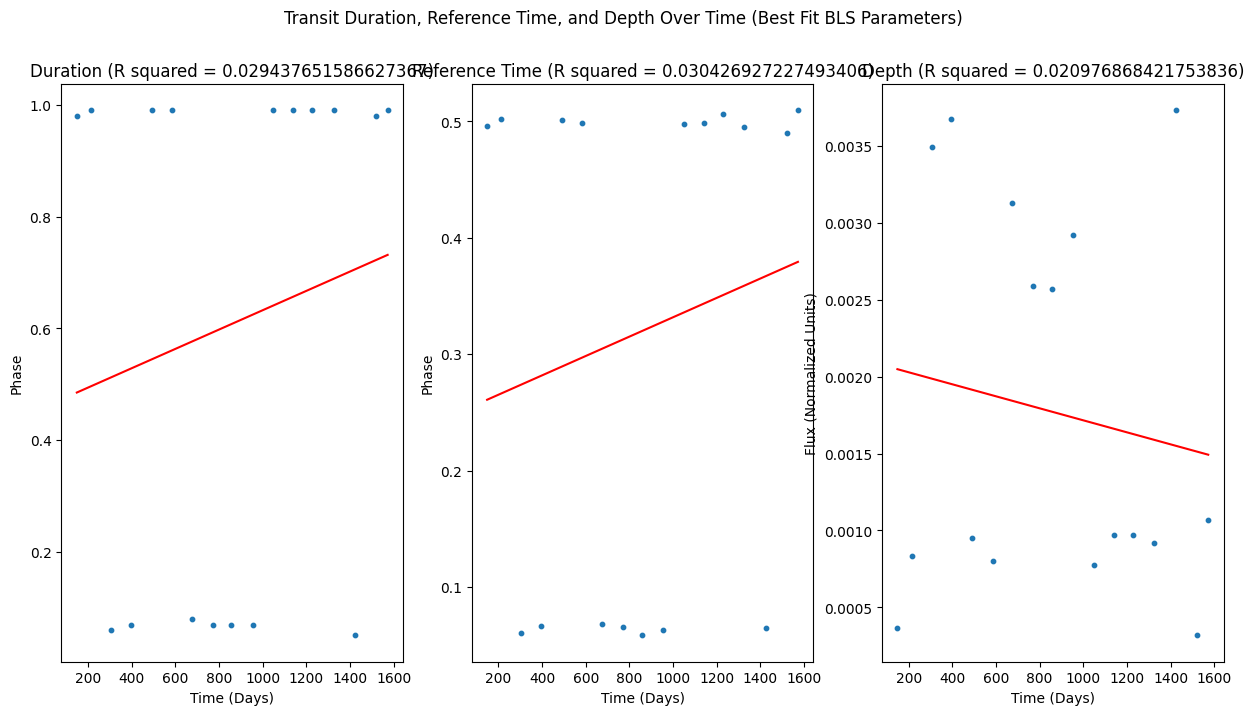

In [94]:
plt.figure(figsize=standard_figsize)

# Transit Fitting
quarter = 1
with sortToPhase(lc_list[quarter]) as quarter_lc:
    phase_binned, flux_binned = timeBin(quarter_lc.phase, quarter_lc.flux, bins=np.arange(0, 1.01, 0.01), aggregate_func=np.mean)
    
    # Fitting with BLS
    model = BoxLeastSquares(quarter_lc.phase, quarter_lc.flux)
    period_grid = np.array([1])
    duration_grid = np.linspace(0.01, 0.99, 100)  # Must be slightly less than one
    results = model.power(period_grid, duration_grid)
    best = np.argmax(results.power)
    duration, ref_time, depth = results.duration[best], results.transit_time[best], results.depth[best]
    
    plt.scatter(quarter_lc.phase, quarter_lc.flux, s=2)
    plt.plot(quarter_lc.phase, model.model(quarter_lc.phase, 1, duration, ref_time), color="red")
    plt.title(f"Phase Curve and BLS Model for Quarter {quarter}")
    plt.xlabel("Phase")
    plt.ylabel("Flux (Normalized Units)")

plt.show()

# Box Least Squares Fitting for Multiple Quarters
durations = np.zeros_like(lc_list)
ref_times = np.zeros_like(lc_list)
depths = np.zeros_like(lc_list)

for idx, quarter_lc in enumerate(lc_list):
    with sortToPhase(quarter_lc):
        phase_binned, flux_binned = timeBin(quarter_lc.phase, quarter_lc.flux, bins=np.arange(0, 1.01, 0.01), aggregate_func=np.mean)

        model = BoxLeastSquares(quarter_lc.phase, quarter_lc.flux)
        period_grid = np.array([1])
        duration_grid = np.linspace(0.01, 0.99, 100)  # Must be slightly less than one
        results = model.power(period_grid, duration_grid)
        best = np.argmax(results.power)
        duration, ref_time, depth = results.duration[best], results.transit_time[best], results.depth[best]
        durations[idx] = duration
        ref_times[idx] = ref_time
        depths[idx] = depth
        
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set(figheight=standard_figsize[1], figwidth=standard_figsize[0])
fig.suptitle("Transit Duration, Reference Time, and Depth Over Time (Best Fit BLS Parameters)")

X = time_list.reshape((-1, 1))

duration_linreg = LinearRegression().fit(X, durations)
ax1.scatter(time_list, durations, s=10)
ax1.plot(time_list, duration_linreg.predict(X), color="red")
ax1.set_title(f"Duration (R squared = {duration_linreg.score(X, durations)})")
ax1.set_xlabel("Time (Days)")
ax1.set_ylabel("Phase")

ref_time_linreg = LinearRegression().fit(X, ref_times)
ax2.scatter(time_list, ref_times, s=10)
ax2.plot(time_list, ref_time_linreg.predict(X), color="red")
ax2.set_title(f"Reference Time (R squared = {ref_time_linreg.score(X, ref_times)})")
ax2.set_xlabel("Time (Days)")
ax2.set_ylabel("Phase")

depth_linreg = LinearRegression().fit(X, depths)
ax3.scatter(time_list, depths, s=10)
ax3.plot(time_list, depth_linreg.predict(X), color="red")
ax3.set_title(f"Depth (R squared = {depth_linreg.score(X, depths)})")
ax3.set_xlabel("Time (Days)")
ax3.set_ylabel("Flux (Normalized Units)")

plt.show()

Fourier Transform Test With Residuals

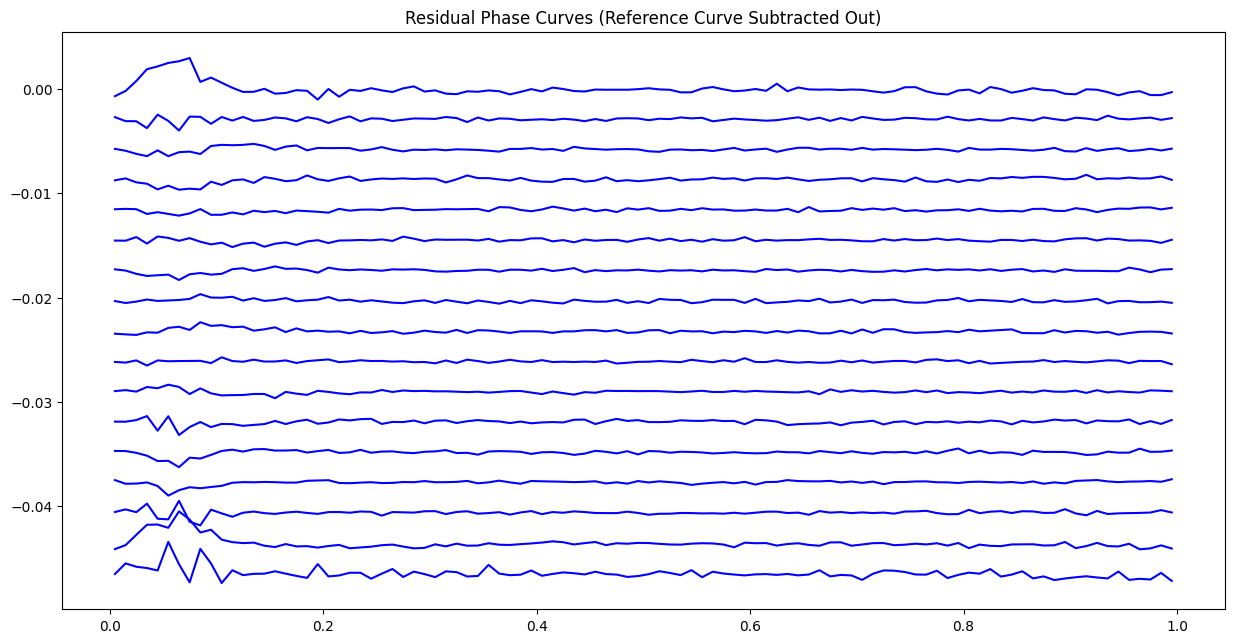

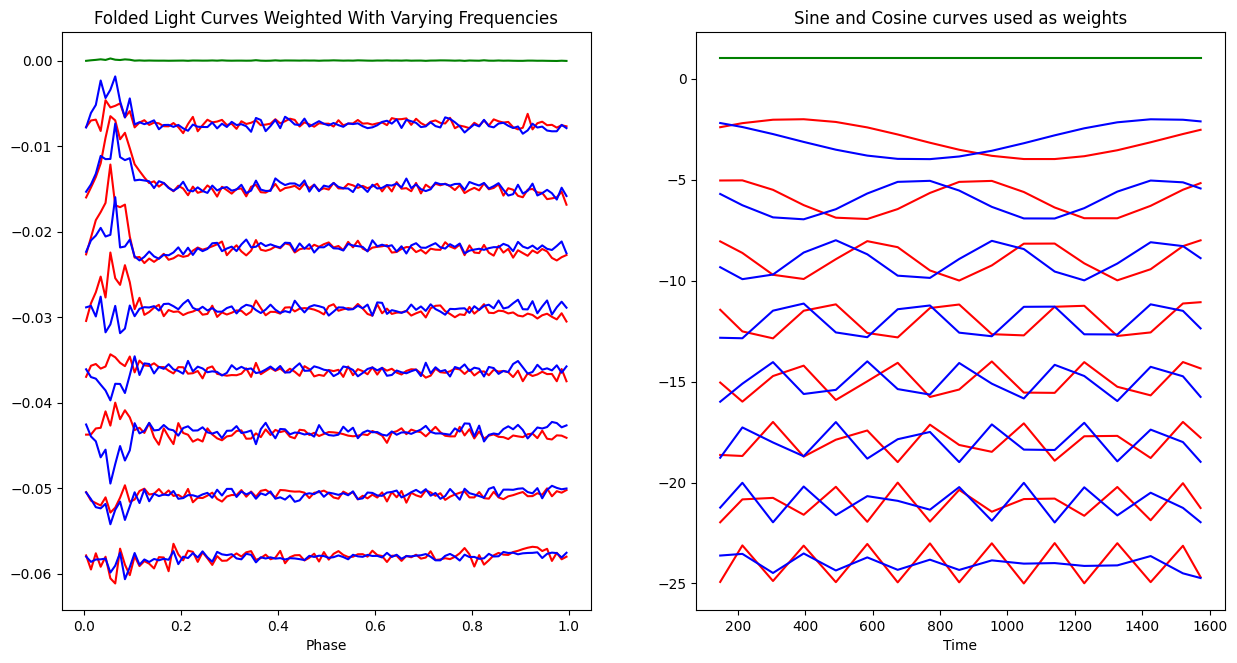

In [98]:
plt.figure(figsize=standard_figsize)

residual_lc_list = np.zeros_like(lc_list, dtype=object)
ref_phase_binned, ref_flux_binned = timeBin(lc.phase, lc.flux, bins=np.arange(0, 1.01, 0.01), aggregate_func=np.mean)
for idx, quarter_lc in enumerate(lc_list):
    phase_binned, flux_binned = timeBin(quarter_lc.phase, quarter_lc.flux, bins=np.arange(0, 1.01, 0.01), aggregate_func=np.mean)
    residual_lc_list[idx] = (phase_binned, flux_binned - ref_flux_binned)
    plt.plot(residual_lc_list[idx][0], residual_lc_list[idx][1] - spacing * idx, color="blue")
plt.title("Residual Phase Curves (Reference Curve Subtracted Out)")

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set(figheight=standard_figsize[1], figwidth=standard_figsize[0])

ax1.set_title("Folded Light Curves Weighted With Varying Frequencies")
ax2.set_title("Sine and Cosine curves used as weights")
ax1.set_xlabel("Phase")
ax2.set_xlabel("Time")

# Getting the average residual light curve
lc_avg = 0
for n, quarter_residual_lc in enumerate(residual_lc_list):
    phase_binned, flux_binned = quarter_residual_lc
    lc_avg += flux_binned
lc_avg /= len(residual_lc_list)
ax1.plot(phase_binned, lc_avg, color="green")
ax2.plot(time_list, np.ones_like(time_list), color="green")

for idx, f in enumerate(frequencies):
    lc_avg_sin = 0
    lc_avg_cos = 0
    for n, quarter_residual_lc in enumerate(residual_lc_list):
        phase_binned, flux_binned = quarter_residual_lc
        lc_avg_sin += flux_binned * np.sin(time_list[n] * f)
        lc_avg_cos += flux_binned * np.cos(time_list[n] * f)
    ax1.plot(phase_binned, lc_avg_sin - np.mean(lc_avg_sin) - spacing * 2.5 * (idx + 1), color="red")
    ax1.plot(phase_binned, lc_avg_cos - np.mean(lc_avg_cos) - spacing * 2.5 * (idx + 1), color="blue")
    ax2.plot(time_list, np.sin(time_list * f) - 3 * (idx + 1), color="red")
    ax2.plot(time_list, np.cos(time_list * f) - 3 * (idx + 1), color="blue")

plt.show()